In [ ]:
!pip install tokenizers==0.8.1.rc1
!pip install simpletransformers==0.45.0
!pip install wandb 
!pip install wordcloud

In [2]:
!wandb login 3cb3fe2145cb9672963a71138f205bc4c4aa61a4
!wandb on

wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
Successfully logged in to Weights & Biases!
W&B enabled, running your script from this directory will now sync to the cloud.


In [4]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import logging
from time import time
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
import random
import os
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed) 
  torch.cuda.manual_seed_all(seed)

In [6]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
original_train = pd.read_csv('gs://mgrdata3/data/original_train.csv')

print("Number of data points in training data:", original_train.shape[0])


original_train.head()

Number of data points in training data: 1306122


qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [9]:
!pip install wordcloud
from wordcloud import STOPWORDS
import re
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(text):
  if '[math]' in text:
    text = re.sub('\[math\].*?math\]', '[formula]', text) #replacing with [formuala]
    
  if 'http' in text or 'www' in text:
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '[url]', text) #replacing with [url]
  return text

In [10]:
# clean_punct
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢','\n']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
  return x

In [11]:
## https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 
# clean word contractions

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [12]:
def data_cleaning_simple(x):
  x = clean_tag(x)
  x = clean_contractions(x)
  x = clean_punct(x)
  return x

In [13]:

def preprocess(function):
  original_train['preprocessed_question_text'] = original_train['question_text'].progress_map(lambda x: function(x))



In [14]:
preprocessing_function = data_cleaning_simple
preprocess(preprocessing_function)

In [15]:
original_train.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target                         preprocessed_question_text  
0       0  How did Quebec nationalists see their province...  
1       0  Do you have an adopted dog  how would you enco...  
2       0  Why does velocity affect time  Does velocity a...  
3       0  How did Otto von Guericke used the Magdeburg h...  
4       0  Can I convert montra helicon D to a mountain b...

In [16]:
original_train = original_train.rename(columns={'preprocessed_question_text': 'text', 'target':'labels'})


In [17]:
train_data = original_train

In [18]:
from sklearn.model_selection import StratifiedKFold
n=5
kf = StratifiedKFold(n_splits=n, random_state=123, shuffle=True)

In [19]:
zero_count = train_data[train_data['labels']==0].shape[0]
zero_count
one_count = train_data[train_data['labels']==1].shape[0]
one_count
total = train_data.shape[0]
weight_for_0 = (1 / zero_count)*(total)/2.0 
weight_for_1 = (1 / one_count)*(total)/2.0
class_weights = [weight_for_0, weight_for_1]
class_weights

[0.5329752748687681, 8.081437940848906]

In [20]:
seed_everything()

In [21]:
ksplit = kf.split(train_data, train_data['labels'])
k = 1
for _ in range(k):
    train_index, val_index = next(ksplit)

train_df = train_data.iloc[train_index]
val_df = train_data.iloc[val_index]

In [22]:
model_type = 'roberta'
model_name = 'roberta-base'
weighted = True
learning_rate =1e-6
max_seq_len = 100
batch_size = 32

In [23]:
fullname =f'{model_type}-{model_name}-fold{k}-b{batch_size}-{learning_rate}-weighted{weighted}-{preprocessing_function.__name__}-semi-frozen'

In [24]:
fullname

'roberta-roberta-base-fold1-b32-1e-06-weightedTrue-data_cleaning_simple-semi-frozen'

In [25]:
transformers_logger = logging.getLogger("simpletransformers")
transformers_logger.setLevel(logging.INFO)

In [ ]:
model_args = {
              'max_seq_length': max_seq_len,
              'train_batch_size': batch_size,
              'eval_batch_size': batch_size,
              'gradient_accumulation_steps': 1,
              'learning_rate': learning_rate,
              'manual_seed': 1234,
              'num_train_epochs':5,
              'use_early_stopping':True,
              'early_stopping_delta':0,
              'early_stopping_patience':3,
              "early_stopping_metric_minimize": False,
              'early_stopping_metric': "f1",
              'early_stopping_consider_epochs': True,
              'evaluate_during_training': True,
              'evaluate_during_training_verbose': True,
              'evaluate_during_training_steps': 0,
              'no_cache': False,
              'reprocess_input_data': True,  
              'overwrite_output_dir': True,
              'save_model_every_epoch': False,
              'save_eval_checkpoints' : False,
              'save_steps' : 0,   
              'logging_steps': 50,
              'fp16': True,
              'verbose':True,
              'wandb_project': 'quora',
              'wandb_kwargs': {'name': fullname},
              'silent': False,
#               'train_custom_parameters_only': True,
                'custom_layer_parameters': [
                    {'layer': 0, 'lr': 1e-06},
                    {'layer': 1, 'lr': 1e-06},
                    {'layer': 2, 'lr': 1e-06},
                    {'layer': 3, 'lr': 1e-06},
                    {'layer': 4, 'lr': 2e-06},
                    {'layer': 5, 'lr': 2e-06},
                    {'layer': 6, 'lr': 2e-06},
                    {'layer': 7, 'lr': 5e-06},
                    {'layer': 8, 'lr': 5e-06},
                    {'layer': 9, 'lr': 5e-06},
                    {'layer': 10, 'lr': 1e-05},
                    {'layer': 11, 'lr': 1e-05},
                    {'layer': 12, 'lr': 1e-05},
                    {'layer': 13, 'lr': 2e-05},
                    {'layer': 14, 'lr': 2e-05},
                    {'layer': 15, 'lr': 2e-05},
                    {'layer': 16, 'lr': 2e-05},
                    {'layer': 17, 'lr': 3e-05},
                    {'layer': 18, 'lr': 3e-05},
                    {'layer': 19, 'lr': 3e-05},
                    {'layer': 20, 'lr': 3e-05},
                    {'layer': 21, 'lr': 4e-05},
                    {'layer': 22, 'lr': 4e-05},
                    {'layer': 23, 'lr': 4e-05}
                ],
              'custom_parameter_groups':[
                                        {"params": ["classifier.dense.weight"],  "lr": 1e-3, },
                                         { "params": ["classifier.dense.bias"], "lr": 1e-3,"weight_decay": 0.0,},
                  
                                         {"params": ["classifier.out_proj.weight"],  "lr": 1e-3, },
                                         { "params": ["classifier.out_proj.bias"], "lr": 1e-3,"weight_decay": 0.0,}
                                         ]
}
if weighted:
  model = ClassificationModel(model_type, model_name, num_labels=2, weight=class_weights, args=model_args)
else:
  model = ClassificationModel(model_type, model_name, num_labels=2, args=model_args)


In [27]:
# # freeze params
# for param in model.model.roberta.parameters():
#     param.requires_grad = False



In [ ]:
from time import time

t0 = time()
model.train_model(train_df, eval_df=val_df, verbose=True, f1=sklearn.metrics.f1_score,acc=sklearn.metrics.accuracy_score)
train_time = time() - t0
print("train time:  %s" % format_time(train_time))

In [29]:
import os
import zipfile

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zip_filename = f'{fullname}_outputs.zip'
zipf = zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED)
zipdir('outputs', zipf)
zipf.close()

In [30]:
!gsutil cp *outputs.zip 'gs://mgrdata3/outputs/'


Copying file://roberta-roberta-base-fold1-b32-1e-06-weightedTrue-data_cleaning_simple-semi-frozen_outputs.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][  1.6 GiB/  1.6 GiB]                                                
Operation completed over 1 objects/1.6 GiB.                                      


In [31]:
if weighted:
  best_model = ClassificationModel(model_type, "outputs/best_model", num_labels=2, weight=class_weights, args=model_args)
else:
  best_model = ClassificationModel(model_type, "outputs/best_model", num_labels=2, args=model_args)

In [32]:
result, model_outputs, wrong_predictions = best_model.eval_model(eval_df=val_df, verbose=True, f1=sklearn.metrics.f1_score,acc=sklearn.metrics.accuracy_score)

wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
predictions, prediction_outputs = best_model.predict(val_df['text'].tolist())

In [34]:
result

{'mcc': 0.7093698347800182,
 'tp': 12031,
 'tn': 240184,
 'fp': 4879,
 'fn': 4131,
 'f1': 0.7275641025641026,
 'acc': 0.9655086611158963,
 'eval_loss': 0.417482484588444}

In [35]:
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import f1_score, classification_report
from sklearn import metrics

f1score = metrics.f1_score(val_df['labels'].tolist(),predictions)


In [36]:
f1score

0.7275641025641026

In [37]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

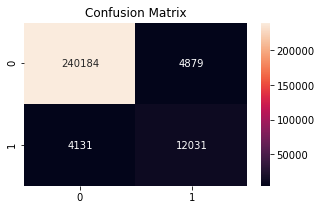

Correctly classified sincere questions: 98.01%
Correctly classified insincere questions: 74.44%


In [38]:
import seaborn as sns

plot_confusion_matrix(val_df['labels'].tolist(), predictions)

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=predictions, y_true=val_df['labels'].tolist(), digits = 4))
      
report = classification_report(y_pred=predictions, y_true=val_df['labels'].tolist(), output_dict=True, digits = 4)
report_df = pd.DataFrame(report).transpose()




              precision    recall  f1-score   support

           0     0.9831    0.9801    0.9816    245063
           1     0.7115    0.7444    0.7276     16162

    accuracy                         0.9655    261225
   macro avg     0.8473    0.8622    0.8546    261225
weighted avg     0.9663    0.9655    0.9659    261225



In [40]:
report_df.to_csv(f'{fullname}report.csv')

In [41]:
!gsutil cp *report.csv 'gs://mgrdata3/outputs/'


Copying file://roberta-roberta-base-fold1-b32-1e-06-weightedTrue-data_cleaning_simple-semi-frozenreport.csv [Content-Type=text/csv]...
/ [1 files][  409.0 B/  409.0 B]                                                
Operation completed over 1 objects/409.0 B.                                      


In [42]:
text_file = open(f'{fullname}report.txt', "w")
text_file.write(classification_report(y_pred=predictions, y_true=val_df['labels'].tolist()))
text_file.close()

In [43]:
!gsutil cp *report.txt 'gs://mgrdata3/outputs/'

Copying file://roberta-roberta-base-fold1-b32-1e-06-weightedTrue-data_cleaning_simple-semi-frozenreport.txt [Content-Type=text/plain]...
/ [1 files][  326.0 B/  326.0 B]                                                
Operation completed over 1 objects/326.0 B.                                      


In [44]:
def f1_with_threshold_selection(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        # print("F1 score at threshold {0} is {1}".format(thresh, res))

    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    print("Best f1 score: ", best_f1)
    return best_f1, best_thresh